In [1]:
from datetime import datetime
import os
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pickle
# Ignore UserWarnings from Keras
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

## Decision Making:
- Since openweather only offer hourly prediction weather data, we predict bikes data hourly
- To make the model be able to capture the hour feature's nature, we use cyclical encoding for hour feature
- Since we are going to train each model for each station, we drop station_id and capacity in each station's data
- We estimate average temperature, relative humidity and barometric pressure from max, min and standard deviation and merge them averagely into each hour

## Chosen features:
- hour
- temperature_celsius
- relative_humidity_percent
- barometric_pressure_hpa
- is_holiday
- is_weekend

## Predictions:
- num_bikes_available
- num_docks_available

In [2]:
# Load the dataset and preprocess it for each station
if os.path.isfile('training_data/final_merged_data.csv'):
    data = pd.read_csv("training_data/final_merged_data.csv")
    df = pd.DataFrame()
    
    # choose relevant features, time as index, station_id as index for each station data file
    df['time'] = data['last_reported']
    df['station_id'] = data['station_id']
    df['hour'] = data['hour']
    # estimate average temperature, relative humidity and barometric pressure from max, min and standard deviation
    df['temperature_celsius'] = (data['max_air_temperature_celsius'] + data['min_air_temperature_celsius']) / 2 + (data['air_temperature_std_deviation'] / np.sqrt(3))
    df['relative_humidity_percent'] = (data['max_relative_humidity_percent'] + data['min_relative_humidity_percent']) / 2 + (data['relative_humidity_std_deviation'] / np.sqrt(3))
    df['barometric_pressure_hpa'] = (data['max_barometric_pressure_hpa'] + data['min_barometric_pressure_hpa']) / 2 + (data['barometric_pressure_std_deviation'] / np.sqrt(3))
    # add is_holiday and is_weekend
    ireland_holidays = holidays.country_holidays('IE')
    df['is_holiday'] = data['last_reported'].apply(lambda x: x in ireland_holidays)
    df['is_weekend'] = data['last_reported'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday() in [5, 6])
    # target features
    df['available_bikes'] = data['num_bikes_available']
    df['available_docks'] = data['num_docks_available']
    
    # deal with each station's data by merging hourly data and imputing missing values
    for station_id in df['station_id'].unique():
        df_station = pd.DataFrame(df[df['station_id'] == station_id])
        # station_id is constant column for each station data file, so drop it
        df_station.drop(columns=['station_id'], inplace=True)
        df_station.drop(columns=['time'], inplace=True)
        # Cyclical Encoding for hour feature
        df_station['hour_sin'] = np.sin(2 * np.pi * df_station['hour'] / 23.0).round(6)
        df_station['hour_cos'] = np.cos(2 * np.pi * df_station['hour'] / 23.0).round(6)
        df_station.drop(columns=['hour'], inplace=True)
        # save the data for each station
        df_station.to_csv(f'training_data/station_{station_id}.csv', index=False)
        
    # No available data for station 46
    # so I will not train the model on this station
    station_46 = data[data['station_id']==46]
    if len(station_46)==0:
        print("No data for station 46")

    # all available_bikes and available_docks are 0 for station_51's
    # so I will not train the model on this station
    station_51 = data[data['station_id']==51]
    print(f"Number of rows for station 51: {len(station_51)}")
    if (station_51['num_bikes_available'] == 0).all() and (station_51['num_docks_available'] == 0).all():
        print("All available_bikes and available_docks are 0 for station 51")

    # station_70's data is corrupt, contain only 59 rows of data and all available_bikes and available_docks are 0
    # so I will not train the model on this station
    station_70 = data[data['station_id']==70]
    print(f"Number of rows for station 70: {len(station_70)}")
    if (station_70['num_bikes_available'] == 0).all() and (station_70['num_docks_available'] == 0).all():
        print("All available_bikes and available_docks are 0 for station 70")

    # No available data for station 81
    # so I will not train the model on this station
    station_81 = data[data['station_id']==81]
    if len(station_81)==0:
        print("No data for station 81")


No data for station 46
Number of rows for station 51: 2173
All available_bikes and available_docks are 0 for station 51
Number of rows for station 70: 59
All available_bikes and available_docks are 0 for station 70
No data for station 81


In [3]:
# example data for station 1
data = pd.read_csv(f'training_data/station_1.csv')
data

,temperature_celsius,relative_humidity_percent,barometric_pressure_hpa,is_holiday,is_weekend,available_bikes,available_docks,hour_sin,hour_cos
0,13.945785,84.508653,1002.429434,False,True,21,10,0.000000,1.000000
1,13.890218,84.971355,1002.447898,False,True,20,11,0.000000,1.000000
2,12.252898,88.143412,1000.219630,False,True,20,11,0.979084,0.203456
3,11.363279,89.871821,1000.156166,False,True,20,11,0.997669,-0.068242
4,11.353486,89.996299,1000.137517,False,True,22,9,0.997669,-0.068242
...,...,...,...,...,...,...,...,...,...
2522,8.516351,90.293871,998.235392,False,False,3,28,-0.519584,0.854419
2523,8.524053,90.754723,998.210011,False,False,3,28,-0.519584,0.854419
2524,8.357920,89.275862,998.154826,False,False,3,28,-0.519584,0.854419
2525,7.902053,89.794338,997.935011,False,False,2,29,-0.269797,0.962917


In [4]:
def visualize_prediction(y_test, y_pred, mae_bikes, r2_score_bikes, mae_docks, r2_score_docks, station_id):
    # Plot results for available_bikes
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, 0], label='Actual Bikes', color='green')
    plt.plot(y_pred[:, 0], label='Predicted Bikes', color='red')
    plt.title(f'#{station_id} Station Available Bikes Forecast (MAE: {mae_bikes:.4f}, r2_score: {r2_score_bikes:.4f})')
    plt.xlabel('Random Hour')
    plt.ylabel('Available Bikes')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot results for available_docks
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, 1], label='Actual Docks', color='green')
    plt.plot(y_pred[:, 1], label='Predicted Docks', color='red')
    plt.title(f'#{station_id} Station Available Docks Forecast (MAE: {mae_docks:.4f}, r2_score: {r2_score_docks:.4f})')
    plt.xlabel('Random Hour')
    plt.ylabel('Available Docks')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_model(station_id, visualize=False):
    # Load the data
    data = pd.read_csv(f'training_data/station_{station_id}.csv')
    X = data.drop(['available_bikes', 'available_docks'], axis=1)
    y = data[['available_bikes', 'available_docks']]

    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X.values, y.values, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Initialize the model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))  # Output layer for two targets

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

    # Fit the model
    model.fit(X_train, y_train, epochs=800, batch_size=32, validation_data=(X_val, y_val), verbose=visualize, callbacks=[early_stopping])
    
    # Save the model
    with open(f'trained_model/station_{station_id}_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    # Save the scaler
    with open(f'trained_model/scaler_station_{station_id}.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # Predict using the model
    with open(f'trained_model/station_{station_id}_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open(f'trained_model/scaler_station_{station_id}.pkl', 'rb') as f:
        scaler = pickle.load(f)
    X_test = scaler.transform(X_test)
    y_pred = model.predict(X_test, verbose=visualize)

    # Evaluate each target separately
    mae_bikes = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
    mae_docks = mean_absolute_error(y_test[:, 1], y_pred[:, 1])

    r2_score_bikes = r2_score(y_test[:, 0], y_pred[:, 0])
    r2_score_docks = r2_score(y_test[:, 1], y_pred[:, 1])
    
    if visualize:
        print(f"R2 Score for available_bikes: {r2_score_bikes}")
        print(f"R2 Score for available_docks: {r2_score_docks}")

        print(f"Mean Absolute Error for available_bikes: {mae_bikes}")
        print(f"Mean Absolute Error for available_docks: {mae_docks}")
        
        visualize_prediction(y_test, y_pred, mae_bikes, r2_score_bikes, mae_docks, r2_score_docks, station_id)
        
    return mae_bikes, r2_score_bikes, mae_docks, r2_score_docks

Epoch 1/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 337.2550 - val_loss: 317.3135
Epoch 2/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 317.1420 - val_loss: 299.1664
Epoch 3/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 298.4622 - val_loss: 278.0887
Epoch 4/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 279.3029 - val_loss: 252.5448
Epoch 5/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 260.2595 - val_loss: 223.9992
Epoch 6/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 229.1057 - val_loss: 195.0114
Epoch 7/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 199.3475 - val_loss: 162.5825
Epoch 8/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165.3362 - val_loss: 130.7456
Epoch 9/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137.0731 - val_loss: 101.6833
Epoch 10/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.0176 - val_loss: 80.3218
Epoch 11/800
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91.2957 - val_loss: 63.2235
Epoch 12/800
64/64 ━━━

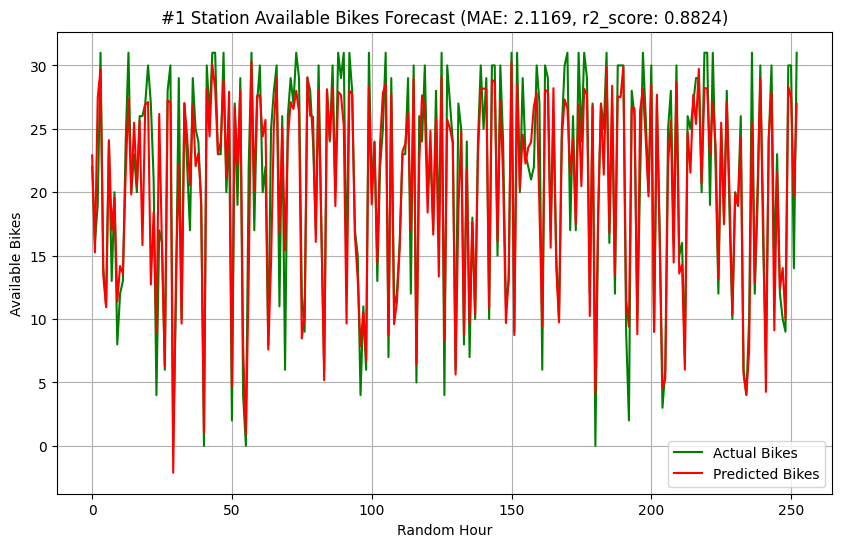

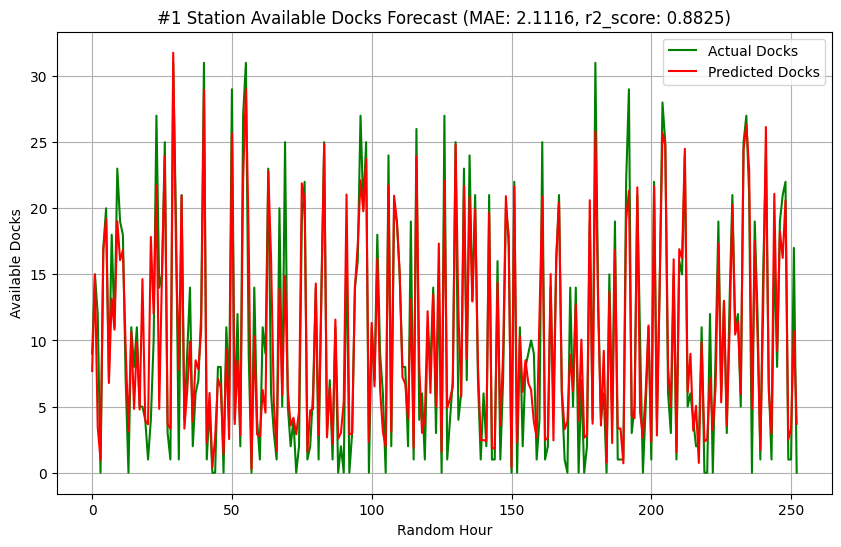

In [5]:
for station_id in range(1,118):
    if (station_id == 46 or station_id == 51 or station_id == 70 or station_id == 81): # skip these stations due to limited data
        continue
    if (station_id == 1):
        visualize = True # visualize the training process for station 1
    else:
        visualize = False
    mae_bikes, r2_score_bikes, mae_docks, r2_score_docks = train_model(station_id, visualize)
    with open(f'model_results.txt', 'a') as f:
        f.write(f'Station {station_id}: MAE bikes: {mae_bikes}, R2 score bikes: {r2_score_bikes}, MAE docks: {mae_docks}, R2 score docks: {r2_score_docks}\n')